In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [2]:
#用pandas讀取文件，並顯示前三行內容
raw_df = pd.read_csv('listings-2.csv',encoding='utf-8')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
print('欄位數:',len(raw_df.columns))
raw_df.head(3)

The dataset contains 9937 Airbnb listings
欄位數: 106


C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,68396,https://www.airbnb.com/rooms/68396,20190730190716,2019-07-30,Zhongxiao Dunhua Studio C near MRT,Prime location! Right in the center of Taipei'...,Located at Zhongxiao East Road of Daan distric...,Prime location! Right in the center of Taipei'...,none,NaN,[Additional Service] - Flat Iron and Iron Boar...,NaN,NaN,NaN,[ Tenant Policy ] The minimum stay is 1 mont...,NaN,NaN,https://a0.muscache.com/im/pictures/b82f75f2-8...,NaN,339014,https://www.airbnb.com/users/show/339014,Lisa,2011-01-07,"Taipei, Taiwan",Hello world!! My name is Lisa and I'm super ex...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/339014/profil...,https://a0.muscache.com/im/users/339014/profil...,Da'an,12.0,12.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,"Daan District, Taiwan",Da'an,大安區,NaN,Daan District,NaN,106,Taipei,"Daan District, Taiwan",TW,Taiwan,25.04258,121.55365,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,"$1,555.00",NaN,"$37,310.00","$9,328.00",NaN,2,$0.00,7,365,7,7,365,365,7.0,365.0,2 months ago,t,3,3,30,305,2019-07-30,2,0,2013-05-23,2018-06-20,100.0,9.0,10.0,10.0,10.0,10.0,10.0,f,NaN,"{""Taiwan VAT Tax""}",f,f,strict_14_with_grace_period,f,f,12,12,0,0,0.03
1,68398,https://www.airbnb.com/rooms/68398,20190730190716,2019-07-30,Tonghua Vacation Studio C,Convenient location; close to MRT and walking ...,Private Studio apartment with ensuite bathroom...,Convenient location; close to MRT and walking ...,none,Locates in a quiet neighborhood of Tonghua Str...,Please note that there is no elevator in the b...,7 mind walk to MRT Xinyi Anhe Station 10 minut...,"26"" TV Sofa couch & Coffee table Queen size do...",NaN,[ Tenant Policy ] The minimum stay is 1 mont...,NaN,NaN,https://a0.muscache.com/im/pictures/28357420/c...,NaN,339014,https://www.airbnb.com/users/show/339014,Lisa,2011-01-07,"Taipei, Taiwan",Hello world!! My name is Lisa and I'm super ex...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/339014/profil...,https://a0.muscache.com/im/users/339014/profil...,Da'an,12.0,12.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,"Daan District, Taiwan",Da'an,大安區,NaN,Daan District,NaN,106,Taipei,"Daan District, Taiwan",TW,Taiwan,25.02925,121.

In [5]:
#先刪除爬取與房源相關的欄位資訊
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_identity_verified', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

In [6]:
#用pandas轉換天數
df.host_since = pd.to_datetime(df.host_since) 

#計算房東加入時間到2019.8.1的總天數
df['host_days_active'] = (datetime(2019, 8, 1) - df.host_since).astype('timedelta64[D]')

#顯示平均與中位天數
print("平均 days as host:", round(df['host_days_active'].mean(),0))
print("中位 days as host:", df['host_days_active'].median())

平均 days as host: 1252.0
中位 days as host: 1267.5


In [11]:
#確認空值數量
df.host_since.isna().sum()

3

In [7]:
#將空值的三筆替換為中位天數
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

In [12]:
#用pandas轉換天數
df.first_review = pd.to_datetime(df.first_review) 

#計算房東first_review到2019.8.1的總天數
df['first_review_to_20190801'] = (datetime(2019, 8, 1) - df.first_review).astype('timedelta64[D]')

In [13]:
print(f"Airbnb首位房東加入時間為 {min(df.host_since).strftime('%d %B %Y')}, and '最多加入的時間為' {max(df.host_since).strftime('%d %B %Y')}.")

Airbnb首位房東加入時間為 19 August 2009, and '最多加入的時間為' 29 July 2019.


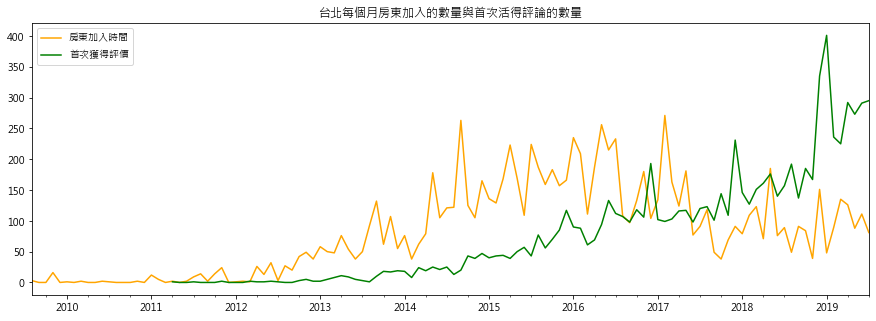

In [14]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='房東加入時間', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='首次獲得評價', color='green')
plt.title('台北每個月房東加入的數量與首次活得評論的數量')
plt.legend()
plt.xlim('2009-08-01', '2019-07-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [15]:
#時間標準化，參考用
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [16]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='原始曲線')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='取log')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='季節性')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='no use')
    plt.legend(loc='upper left')
    plt.tight_layout()

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


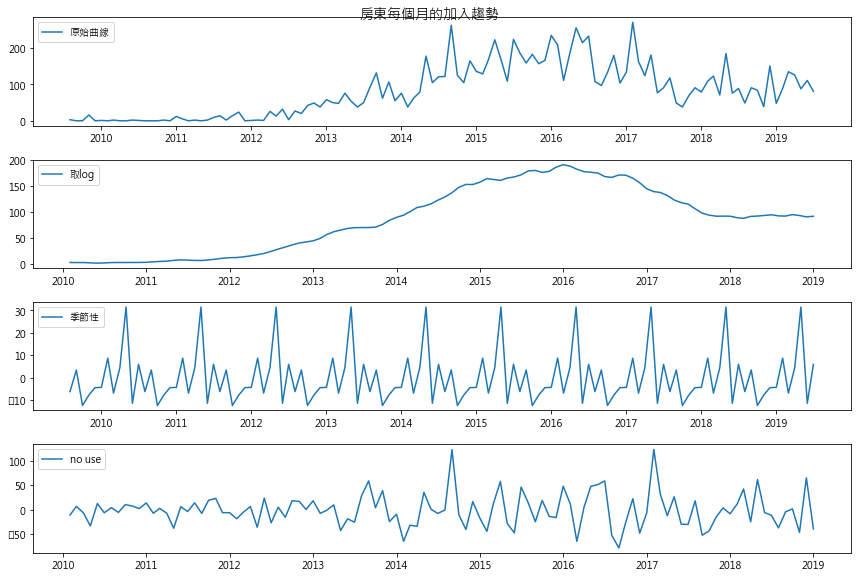

In [17]:
decompose_time_series(ts_host_since, title='房東每個月的加入趨勢')

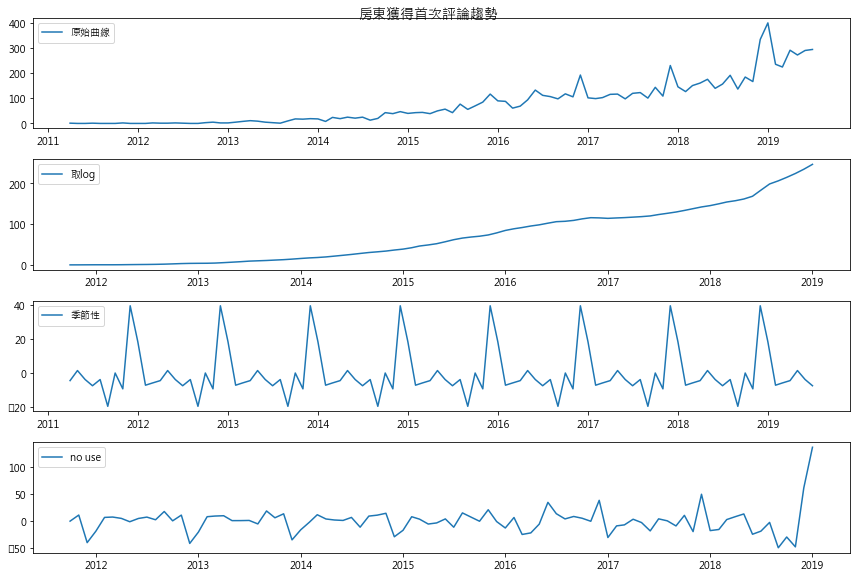

In [18]:
decompose_time_series(ts_first_review, title='房東獲得首次評論趨勢')